---
title: "Climate DT Parameter Series Plot- Data Access using DEDL HDA"
subtitle: "This notebook authenticates a user with DestinE services, constructs and submits data requests to the DEDL HDA API for Climate Digital Twin projections, polls for availability, downloads GRIB data for multiple years, and visualizes it using EarthKit."
author: " Micheal Schick (EUMETSAT), Serena Avolio (EUMETSAT/Starion)"
tags: [HDA, ECMWF, Authentication, Digital Twin]
thumbnail: ../../img/ECMWF.png
license: MIT
copyright: "© 2025 EUMETSAT"
---
<div style="margin: 6px 0;">
  <a href="https://jupyter.central.data.destination-earth.eu/user-redirect/lab/tree/DestinE-DataLake-Lab/HDA/DestinE_Digital_Twins/DEDL-HDA-EO.ECMWF.DAT.DT_CLIMATE-Series.ipynb" target="_blank" style="text-decoration: none;">
    <span class="launch">🚀 Launch in JupyterHub</span>
  </a>
</div>

<div class="alert alert-block alert-warning">
<b> Prerequisites: </b><ul>
   <li>To search and access DEDL data a <a href="https://platform.destine.eu/"> DestinE user account</a> is needed</li>
   <li>To search and access DT data an <a href="https://platform.destine.eu/support-pages/access-policy/"> upgraded access</a> is needed.</li></ul>
<b> References: </b><ul>
    <li><a href="https://destine-data-lake-docs.data.destination-earth.eu/en/latest/dedl-discovery-and-data-access/Use-of-Harmonized-Data-Access/Use-of-Harmonized-Data-Access.html">DestinE Data Lake (DEDL) Harmonized Data Access (HDA) documentation</a> </li>
    <li> <a href="https://destine.ecmwf.int/climate-change-adaptation-digital-twin-climate-dt/">Climate Change Adaptation DT (Climate DT)</a></li>
    <li> <a href="https://confluence.ecmwf.int/display/DDCZ/Climate+DT+Phase+1+data+catalogue">Climate DT data catalogue</a></li></ul>
<b> Credit: </b><ul>
    <li> Earthkit and HDA Polytope used in this context are both packages provided by the European Centre for Medium-Range Weather Forecasts (ECMWF).</li></ul>
</div>

This notebook demonstrates how to use the **HDA (Harmonized Data Access)** API to query and access Climate DT data to plot a parameter series.
Below the main steps covered by this tutorial.

1. [Setup](#DEDL-HDA-EO.ECMWF.DAT.DT_CLIMATE-Series.ipynb-Setup): Import the required libraries. 
2. [Order and Download](#DEDL-HDA-EO.ECMWF.DAT.DT_CLIMATE-Series.ipynb-Order-and-Download): How to filter and download climate Dt data.
3. [Plot](#DEDL-HDA-EO.ECMWF.DAT.DT_CLIMATE-Series.ipynb-EarthKit): How to visualize hourly data on single levels data through Earthkit.

(DEDL-HDA-EO.ECMWF.DAT.DT_CLIMATE-Series.ipynb-Setup)=
# Setup

Import all the required packages.

In [1]:
import destinelab as deauth
import json
import datetime
import importlib.metadata

import requests
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry
import os
from getpass import getpass
from tqdm import tqdm
import time
from datetime import datetime
from urllib.parse import unquote
from time import sleep
from IPython.display import JSON

(DEDL-HDA-EO.ECMWF.DAT.DT_CLIMATE-Series.ipynb-Order-and-Download)=
# Order and Download

## Obtain Authentication Token

To perform our request we need to be authenticated. 
Below to request of an authentication token.

In [2]:
DESP_USERNAME = input("Please input your DESP username: ")
DESP_PASSWORD = getpass("Please input your DESP password: ")

auth = deauth.AuthHandler(DESP_USERNAME, DESP_PASSWORD)
access_token = auth.get_token()
if access_token is not None:
    print("DEDL/DESP Access Token Obtained Successfully")
else:
    print("Failed to Obtain DEDL/DESP Access Token")

auth_headers = {"Authorization": f"Bearer {access_token}"}

Please input your DESP username:  serena.avolio
Please input your DESP password:  ········


Response code: 200
DEDL/DESP Access Token Obtained Successfully


### Check if DT access is granted

If DT access is not granted, you will not be able to execute the rest of the notebook.

In [3]:
import importlib
installed_version = importlib.metadata.version("destinelab")
version_number = installed_version.split('.')[1]
if((int(version_number) >= 8 and float(installed_version) < 1) or float(installed_version) >= 1):
    auth.is_DTaccess_allowed(access_token)

DT Output access allowed


## HDA Endpoints
HDA API is based on the Spatio Temporal Asset Catalog specification (STAC).
When accessing DestinE data through the HDA API, it is useful to define a small set of configuration constants upfront. These typically include:

- The STAC API endpoint exposed by HDA
- The collection name

While the collection name can be specified as a constant, it does not need to be known in advance, as available collections can be discovered dynamically using the discovery API. 

For this example we want to access the Future Projection obtained using the IFS-NEMO model of the Climate Change Adaptation Digital Twin data. 
To find the right collection ID to use for querying HDA we can use the free text search offered by the HDA Discovery API searching for, e.g., Climate Change Adaptation Digital Twin, Future Projection and IFS-NEMO: <a href="https://hda-staging.lumi.data.destination-earth.eu/stac/v2/collections?limit=10&q=%22Climate%20Change%20Adaptation%20Digital%20Twin%22,%22Future%20Projection%22,%22%20IFS-NEMO%22">HDA Discovery API

The result of this operation will give us the collection ID and some other useful information like the temporal extent and the available parameters.


In [4]:
HDA_STAC_ENDPOINT="https://hda-staging.lumi.data.destination-earth.eu/stac/v2"
print("STAC endpoint: ", HDA_STAC_ENDPOINT)

STAC endpoint:  https://hda-staging.lumi.data.destination-earth.eu/stac/v2


In [5]:
HDA_DISCOVERY_ENDPOINT = HDA_STAC_ENDPOINT+'/collections'
print("HDA discovery endpoint: ", HDA_DISCOVERY_ENDPOINT)

HDA discovery endpoint:  https://hda-staging.lumi.data.destination-earth.eu/stac/v2/collections


### HDA Discovery

In [6]:
discovery_json=(requests.get(HDA_DISCOVERY_ENDPOINT,params = {"q": '"Climate Change Adaptation Digital Twin","Future Projection","IFS-NEMO"'}).json())

#print("Result from the free text search on the HDA Discovery API : ")
#JSON(discovery_json)

In [7]:
print("The discovery result give us\nthe collection ID : ", discovery_json["collections"][0].get("id"))
print("\nIts time extension : ", discovery_json["collections"][0].get("extent").get("temporal").get("interval"))
print("\nThe available parameters: ", discovery_json["collections"][0].get("cube:variables").keys())

print("\nThe information related to each parameter, e.g. the 2 metre temperature: ")
JSON(discovery_json["collections"][0].get("cube:variables").get("2_metre_temperature(sfc)"))

The discovery result give us
the collection ID :  EO.ECMWF.DAT.D1.DT_CLIMATE.G1.SCENARIOMIP_SSP3-7.0_IFS-NEMO.R1

Its time extension :  [['2020-01-01T00:00:00Z', '2039-12-31T23:59:59Z']]

The available parameters:  dict_keys(['100_metre_U_wind_component(hl)', '100_metre_V_wind_component(hl)', '10_metre_U_wind_component(sfc)', '10_metre_V_wind_component(sfc)', '2_metre_dewpoint_temperature(sfc)', '2_metre_temperature(sfc)', 'Boundary_layer_height(sfc)', 'Charnock(sfc)', 'Evaporation(sfc)', 'Geopotential(pl)', 'Geopotential(sfc)', 'High_cloud_cover(sfc)', 'Land-sea_mask(sfc)', 'Low_cloud_cover(sfc)', 'Mean_sea_level_pressure(sfc)', 'Medium_cloud_cover(sfc)', 'Potential_vorticity(pl)', 'Relative_humidity(pl)', 'Skin_temperature(sfc)', 'Snow_depth(sfc)', 'Snow_depth_water_equivalent(sol)', 'Snowfall(sfc)', 'Specific_cloud_liquid_water_content(pl)', 'Specific_humidity(pl)', 'Sub-surface_runoff(sfc)', 'Surface_long-wave_(thermal)_radiation_downwards(sfc)', 'Surface_net_long-wave_(thermal)_ra

<IPython.core.display.JSON object>

In [8]:
COLLECTION_ID="EO.ECMWF.DAT.D1.DT_CLIMATE.G1.SCENARIOMIP_SSP3-7.0_IFS-NEMO.R1"

## Order and download data
After selecting the correct collection, we need to set up a filter to isolate the data we want—here, the temperature in a certain date each 4 years considering the time extension of our collection.
We already retrieved the temperature parameter details (parameter_ID, leveltype, product_type) using the Discovery API. With this information, we can:

- use *search* to get the precise body and URL needed for the request
- use *order* to directly request the data

In this example, we proceed directly with placing the data order using the order endpoint.

In [9]:
datechoice = "20200731"

filter_params = {
        "resolution": "high",      # standard/ high 
        "time": "0000",            # choose the hourly slot(s)
        "type": "fc",              # fixed forecasted fields
        "levtype": "sfc",          # Surface fields (levtype=sfc),
        "param": "167",            # 2m Temperature parameter
        "date":datechoice
    }

In [10]:
# Initialize a list to store filenames
filenames = []

# Define start and end years
start_year = 2020
end_year = 2039

#timeout and step for polling (sec)
TIMEOUT = 300
STEP = 1
ONLINE_STATUS = "online"

# Loop 
for year in range(start_year, end_year+1,4):
    # Create a datetime object 
    obsdate = datetime(year, 7, 31)
    datechoice = obsdate.strftime("%Y%m%d")
    filter_params["date"]=datechoice
    response = requests.post(f"{HDA_STAC_ENDPOINT}/collections/{COLLECTION_ID}/order", json=filter_params, headers=auth_headers)

    if response.status_code != 200:
        print(response.content)
    response.raise_for_status()

    ordered_item = response.json()

    product_id = ordered_item["id"]
    storage_tier = ordered_item["properties"].get("storage:tier", "online")
    order_status = ordered_item["properties"].get("order:status", "unknown")
    federation_backend = ordered_item["properties"].get("federation:backends", [None])[0]

    print(f"Product ordered: {product_id}")
    print(f"Provider: {federation_backend}")
    print(f"Storage tier: {storage_tier} (product must have storage tier \"online\" to be downloadable)")
    print(f"Order status: {order_status}")      

    self_url = f"{HDA_STAC_ENDPOINT}/collections/{COLLECTION_ID}/items/{product_id}"
    item = {}

    for i in range(0, TIMEOUT, STEP):
        print(f"Polling {i + 1}/{TIMEOUT // STEP}")

        response = requests.get(self_url, headers=auth_headers)
        if response.status_code != 200:
            print(response.content)
        response.raise_for_status()
        item = response.json()

        storage_tier = item["properties"].get("storage:tier", ONLINE_STATUS)

        if storage_tier == ONLINE_STATUS:
            download_url = item["assets"]["downloadLink"]["href"]
            print("Product is ready to be downloaded.")
            print(f"Asset URL: {download_url}")
            break
        sleep(STEP)
    else:
        order_status = item["properties"].get("order:status", "unknown")
        print(f"We could not download the product after {TIMEOUT // STEP} tries. Current order status is {order_status}")
    
    response = requests.get(download_url, stream=True, headers=auth_headers)
    response.raise_for_status()

    content_disposition = response.headers.get('Content-Disposition')
    total_size = int(response.headers.get("content-length", 0))
    if content_disposition:
        filename = content_disposition.split('filename=')[1].strip('"')
        filename = unquote(filename)
    else:
        filename = os.path.basename(url)

    # Open a local file in binary write mode and write the content
    print(f"downloading {filename}")

    with tqdm(total=total_size, unit="B", unit_scale=True) as progress_bar:
        with open(filename, 'wb') as f:
            for data in response.iter_content(1024):
                progress_bar.update(len(data))
                f.write(data)
               
    # Add the filename to the list
    filenames.append(filename)

Product ordered: a8bc3aaf-99c1-47ec-aad0-d5a0ed1c95ab
Provider: dedt_lumi
Storage tier: offline (product must have storage tier "online" to be downloadable)
Order status: ordered
Polling 1/300
Polling 2/300
Polling 3/300
Product is ready to be downloaded.
Asset URL: https://hda-download-staging.lumi.data.destination-earth.eu/data/dedt_lumi/EO.ECMWF.DAT.D1.DT_CLIMATE.G1.SCENARIOMIP_SSP3-7.0_IFS-NEMO.R1/a8bc3aaf-99c1-47ec-aad0-d5a0ed1c95ab/downloadLink
downloading a8bc3aaf-99c1-47ec-aad0-d5a0ed1c95ab.grib", attachment; 


26.2MB [00:00, 49.2MB/s]


Product ordered: 377ec3d6-fc08-4399-809e-58fdc566e906
Provider: dedt_lumi
Storage tier: offline (product must have storage tier "online" to be downloadable)
Order status: ordered
Polling 1/300
Polling 2/300
Product is ready to be downloaded.
Asset URL: https://hda-download-staging.lumi.data.destination-earth.eu/data/dedt_lumi/EO.ECMWF.DAT.D1.DT_CLIMATE.G1.SCENARIOMIP_SSP3-7.0_IFS-NEMO.R1/377ec3d6-fc08-4399-809e-58fdc566e906/downloadLink
downloading 377ec3d6-fc08-4399-809e-58fdc566e906.grib", attachment; 


26.2MB [00:00, 51.3MB/s]


Product ordered: f1f2a95a-2573-4ed9-a591-3189d58e5918
Provider: dedt_lumi
Storage tier: offline (product must have storage tier "online" to be downloadable)
Order status: ordered
Polling 1/300
Polling 2/300
Product is ready to be downloaded.
Asset URL: https://hda-download-staging.lumi.data.destination-earth.eu/data/dedt_lumi/EO.ECMWF.DAT.D1.DT_CLIMATE.G1.SCENARIOMIP_SSP3-7.0_IFS-NEMO.R1/f1f2a95a-2573-4ed9-a591-3189d58e5918/downloadLink
downloading f1f2a95a-2573-4ed9-a591-3189d58e5918.grib", attachment; 


26.2MB [00:00, 51.7MB/s]


Product ordered: 28e204f3-b195-4331-a3de-c288229055e7
Provider: dedt_lumi
Storage tier: offline (product must have storage tier "online" to be downloadable)
Order status: ordered
Polling 1/300
Polling 2/300
Product is ready to be downloaded.
Asset URL: https://hda-download-staging.lumi.data.destination-earth.eu/data/dedt_lumi/EO.ECMWF.DAT.D1.DT_CLIMATE.G1.SCENARIOMIP_SSP3-7.0_IFS-NEMO.R1/28e204f3-b195-4331-a3de-c288229055e7/downloadLink
downloading 28e204f3-b195-4331-a3de-c288229055e7.grib", attachment; 


26.2MB [00:00, 49.2MB/s]


Product ordered: bf63bfe0-7b7c-4408-ad78-9dc3009103ca
Provider: dedt_lumi
Storage tier: offline (product must have storage tier "online" to be downloadable)
Order status: ordered
Polling 1/300
Polling 2/300
Polling 3/300
Product is ready to be downloaded.
Asset URL: https://hda-download-staging.lumi.data.destination-earth.eu/data/dedt_lumi/EO.ECMWF.DAT.D1.DT_CLIMATE.G1.SCENARIOMIP_SSP3-7.0_IFS-NEMO.R1/bf63bfe0-7b7c-4408-ad78-9dc3009103ca/downloadLink
downloading bf63bfe0-7b7c-4408-ad78-9dc3009103ca.grib", attachment; 


26.2MB [00:00, 45.5MB/s]


(DEDL-HDA-EO.ECMWF.DAT.DT_CLIMATE-Series.ipynb-EarthKit)=
## EarthKit

Lets plot the result file with [EarthKit](https://earthkit.readthedocs.io/en/latest/index.html) selecting only the Europe area in the plot.

In [11]:
import earthkit.data
import earthkit.plots

In [12]:
# Iterate over filenames
data=[]
for filename in filenames:
    data.append( earthkit.data.from_source("file", filename))


In [13]:
STYLE = earthkit.plots.styles.Style(
    colors="Spectral_r",
    levels=range(-30, 31),
    units="celsius",
        # Extend the colorbar at both ends
    extend="both",
)

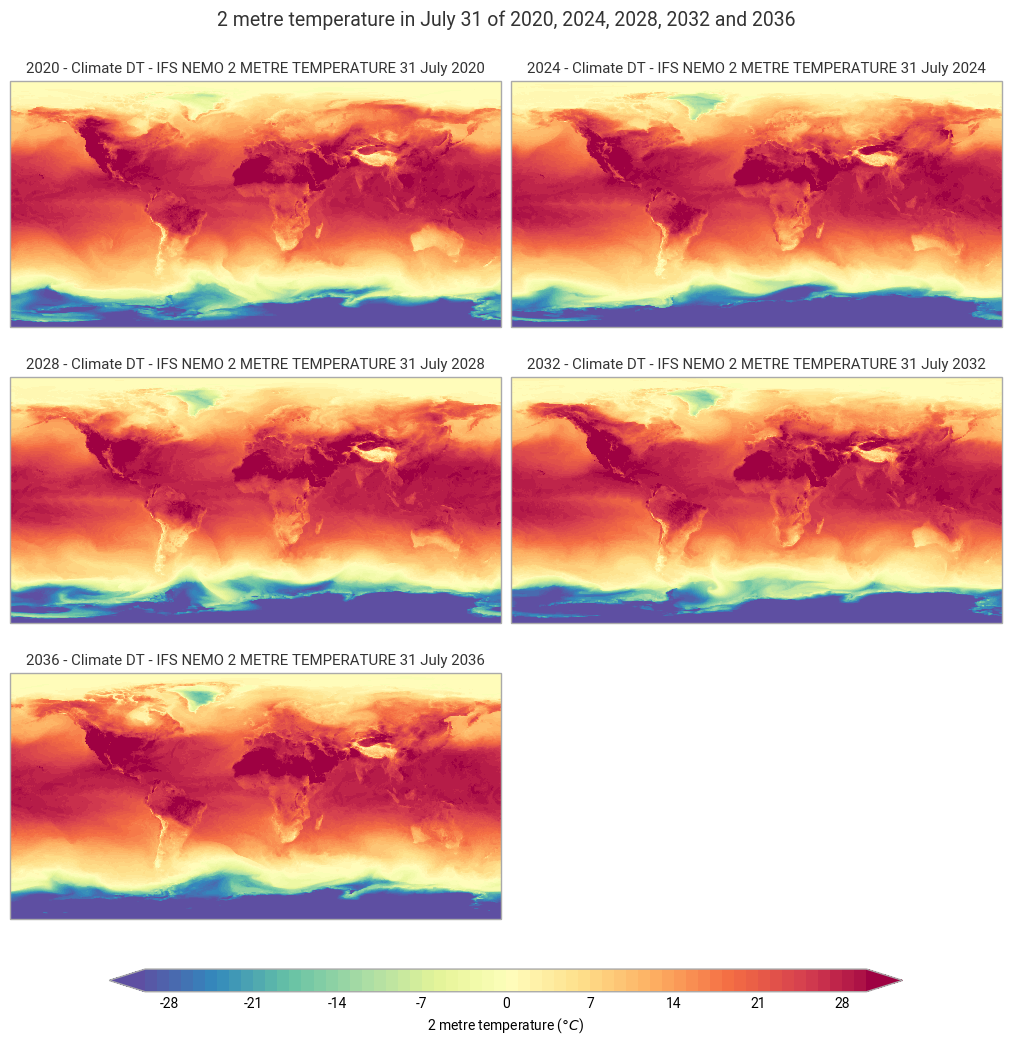

In [14]:
figure = earthkit.plots.Figure(rows=3, columns=2, size=(10, 10))

for i, year in enumerate(range(start_year, end_year+1,4)):
    subplot = figure.add_map()
    subplot.contourf(data[i], style=STYLE)
    subplot.title(f"{year} - Climate DT - IFS NEMO {{short_name!u}} {{time:%d %B %Y}}")


figure.title("{variable_name} in {time:%B %d} of {time:%Y}", fontsize=14)

figure.legend(label="{variable_name!l} ({units})")

figure.show()

In [24]:
for filename in filenames:
    os.remove(filename)

FileNotFoundError: [Errno 2] No such file or directory: 'fd12a931-669c-498d-8028-b5bc80f8cbf8.grib", attachment; '